# **Early proper time behaviour of beauty quark momentum broadening**

### Default simulation parameters for the Glasma and the Wong solvers

Simulation parameters chosen for a Glasma characterized by a saturation momentum $Q_s=2\,\mathrm{GeV}$ and a beauty quark.

In [2]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 2.0     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# Wong solver 
mass = 1      
tau_form = 0
px = 10
ntp = 10**5  
nevents = 5    
representation = 'fundamental'      
boundary = 'periodic'       

### Set environment variables

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_mom_toy, init_pos, init_charge

Using CUDA
Using SU(3)
Using double precision
Using double precision


### Simulation routine for evolving the Glasma & solving Wong's equations
Computes and stores momentum broadening.

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('px', px / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad = np.zeros((maxt-formt, 4))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad"] = mom_broad

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

### Running the Wong solver over multiple Glasma events

In [5]:
mom_broads = []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads.append(output["mom_broad"])

mom_broad = np.mean(mom_broads, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

output = {}
output["mom_broad"], output["tau"] = mom_broad, tau
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_early_jet.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 5: 100%|██████████| 819/819 [04:27<00:00,  3.07it/s]


## Read data from files using Julia

In [26]:
using Pickle

output = Pickle.npyload("wong_early_jet.pickle")
mom_broad, tau = output["mom_broad"], output["tau"]
Qs, hbarc = output["Qs"], output["hbarc"]

(2, 0.197326)

### Plot transverse and longitudinal momentum broadenings, using Makie from Julia

In [24]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

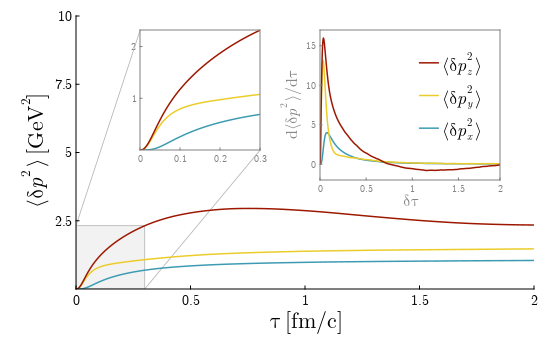

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000095a8ee0, 2750.0, 1750.0)


In [42]:
using CairoMakie
using ColorSchemes
using Makie.GeometryBasics
using ForwardDiff

# segmented_cmap = cgrad(:lapaz, 11, categorical = true)
# colors = [segmented_cmap[9], segmented_cmap[6], segmented_cmap[3]]
wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]
colors = [wesanderson[1], wesanderson[3], wesanderson[5]]

# dimenstion of fundamental representation for SU(3)
DR = 3

fig = Figure(resolution = (550, 350), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        # xlabel=L"\delta \tau\,\mathrm{[fm/c]}", ylabel=L"\langle \delta p^2_{L,T}\,\rangle\,\mathrm{[GeV^2]}",
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle \delta p^2\,\rangle\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

poly!(ax, Rect(0, 0, 0.3, 2.32), color = :grey95, strokecolor = :grey70, strokewidth = 0.8)
lines!(ax, [0, 0.28], [2.32, 9.48], linewidth = 0.8, color=:grey70)
lines!(ax, [0.3, 0.805], [0, 5.1], linewidth = 0.8, color=:grey70)

px = lines!(ax, tau.-tau[1], mom_broad[:, 1]/DR, linewidth = 1.5, color=colors[1])
py = lines!(ax, tau.-tau[1], mom_broad[:, 2]/DR, linewidth = 1.5, color=colors[2])
pz = lines!(ax, tau.-tau[1], mom_broad[:, 3]/DR, linewidth = 1.5, color=colors[3])

limits!(ax, 0, 2, 0, 10)
ax.xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
ax.yticks = ([2.5, 5, 7.5, 10], ["2.5", "5", "7.5", "10"])

ax_zoomin = Axis(fig, bbox = BBox(140, 260, 200, 320), 
        # xlabel=L"\delta \tau", ylabel=L"\langle \delta p_\mu^2\,\rangle",
        xlabelsize = 14, ylabelsize= 14, xticklabelsize=10, yticklabelsize=10,
        xtickalign = 1, xticksize=3, ytickalign=1, yticksize=3, xlabelpadding = -4, xgridvisible = false, ygridvisible = false,
        ytickcolor = :grey, xtickcolor = :grey, yticklabelcolor = :grey, xticklabelcolor = :grey, ylabelcolor = :grey, xlabelcolor = :grey,
        bottomspinecolor = :grey, topspinecolor = :grey, leftspinecolor = :grey, rightspinecolor = :grey)

zoomin_indices = findall(t->t<=0.35, tau)
tau_zoomin = tau[zoomin_indices]
mom_broad_zoomin = mom_broad[zoomin_indices, :]
# lines!(ax_zoomin, tau_zoomin.-tau[1], (mom_broad_zoomin[:, 1]+mom_broad_zoomin[:, 2])/DR, linewidth = 1.5, color=colors[1])
for i in 1:3
        lines!(ax_zoomin, tau_zoomin.-tau[1], mom_broad_zoomin[:, i]/DR, linewidth = 1.5, color=colors[i])
end
limits!(ax_zoomin, 0, 0.3, 0, 2.32)
ax_zoomin.xticks = ([0, 0.1, 0.2, 0.3], ["0", "0.1", "0.2", "0.3"])
ax_zoomin.yticks = ([1, 2], ["1","2"])

ax_inset = Axis(fig, bbox = BBox(320, 500, 170, 320), 
        # xlabel=L"\delta \tau", ylabel=L"\mathrm{d}\langle \delta p^2_{L,T}\,\rangle/\mathrm{d}\tau",
        xlabel=L"\delta \tau", ylabel=L"\mathrm{d}\langle \delta p^2\,\rangle/\mathrm{d}\tau",
        xlabelsize = 16, ylabelsize= 16, xticklabelsize=10, yticklabelsize=10,
        xtickalign = 1, xticksize=3, ytickalign=1, yticksize=3, xlabelpadding = -2, xgridvisible = false, ygridvisible = false,
        ytickcolor = :grey, xtickcolor = :grey, yticklabelcolor = :grey, xticklabelcolor = :grey, ylabelcolor = :grey, xlabelcolor = :grey,
        bottomspinecolor = :grey, topspinecolor = :grey, leftspinecolor = :grey, rightspinecolor = :grey)

# lines!(ax_inset, (tau_zoomin.-tau[1])[2:length(tau_zoomin)], diff(mom_broad_zoomin[:, 1]+mom_broad_zoomin[:, 2]) ./ diff(tau_zoomin.-tau[1]), linewidth = 1.5, color=colors[1])
# lines!(ax_inset, (tau_zoomin.-tau[1])[2:length(tau_zoomin)], diff(mom_broad_zoomin[:, 3]) ./ diff(tau_zoomin.-tau[1]), linewidth = 1.5, color=colors[2])

# lines!(ax_inset, (tau.-tau[1])[2:length(tau)], diff((mom_broad[:, 1]+mom_broad[:, 2])/DR) ./ diff(tau), linewidth = 1.5, color=colors[1])
for i in 1:3
        lines!(ax_inset, (tau.-tau[1])[2:length(tau)], diff(mom_broad[:, i]/DR) ./ diff(tau), linewidth = 1.5, color=colors[i])
end

limits!(ax_inset, 0, 1.95, -2, 17)
ax_inset.xticks = ([0, 0.5, 1, 1.5, 1.95], ["0", "0.5", "1", "1.5", "2"])
ax_inset.yticks = ([0, 5, 10, 15], ["0", "5", "10", "15"])

legend = [L"\langle\delta p_z^2\,\rangle", L"\langle\delta p_y^2\,\rangle", L"\langle\delta p_x^2\,\rangle"]
axislegend(ax_inset, [pz, py, px], legend, labelsize=18, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("final_jet_early_behaviour.png", fig, px_per_unit = 5.0) 